# 1 - Cargamos dataset

In [33]:
import os
from pathlib import Path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


In [34]:
# --- 1. Instalar gdown para descargar desde Google Drive ---
# El flag -q es para una instalación silenciosa.
print("📦 Instalando gdown...")
!pip install -q gdown

# --- 2. Descargar el archivo .ZIP desde Google Drive ---
# ¡IMPORTANTE! Pega aquí el enlace de tu archivo .zip compartido
drive_link = "https://drive.google.com/file/d/139GTZiVlxWrBUf_ww7iUVv0-wSjhDQ77/view?usp=sharing"

# Extraemos el ID de la URL
file_id = drive_link.split('/')[-2]

output_zip = 'thermal_images.zip'
print(f"⬇️  Descargando {output_zip} desde Google Drive...")
!gdown --id {file_id} -O {output_zip} --quiet
print("✅ Descarga completada.")

# --- 3. Descomprimir el archivo ---
output_folder = 'thermal_images'
print(f"\n🌀 Descomprimiendo archivos en la carpeta '{output_folder}'...")
# Creamos el directorio si no existe
output_folder = Path.cwd().joinpath(output_folder)
output_folder.mkdir(exist_ok=True)

# Descomprimimos el zip en la carpeta de destino
!unzip -q -o {output_zip} -d {output_folder}
print("✅ Descompresión finalizada.")

# --- 4. Verificar los archivos ---
folders = output_folder/"Thermal PV Panel Detection Dataset for UAV Inspection"
print(f"\n📄 Contenido del directorio '{folders}':")
for folder in folders.iterdir():
    print(folder.name)


📦 Instalando gdown...
⬇️  Descargando thermal_images.zip desde Google Drive...
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
✅ Descarga completada.

🌀 Descomprimiendo archivos en la carpeta 'thermal_images'...
✅ Descompresión finalizada.

📄 Contenido del directorio '/content/thermal_images/Thermal PV Panel Detection Dataset for UAV Inspection':
train
test
val


## Verificación de imagen y anotación

In [35]:
# Esta función lee una imagen y su archivo de anotación YOLO (.txt)
# y dibuja los bounding boxes para que podamos verificar que todo está correcto.
def verify_annotation(image_path, label_path):
    """
    Displays an image with its bounding boxes drawn.
    """
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    if not os.path.exists(label_path):
        print(f"Label file not found for {os.path.basename(image_path)}")
        return

    with open(label_path, 'r') as f:
        for line in f.readlines():
            # YOLO format: class_id x_center y_center width height
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert YOLO format to pixel coordinates
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)

            # Draw rectangle
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green box
            cv2.putText(img, f"Class: {class_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Verificación de Anotación")
    plt.axis('off')
    plt.show()



Mostrando 9 imágenes de val con sus anotaciones:


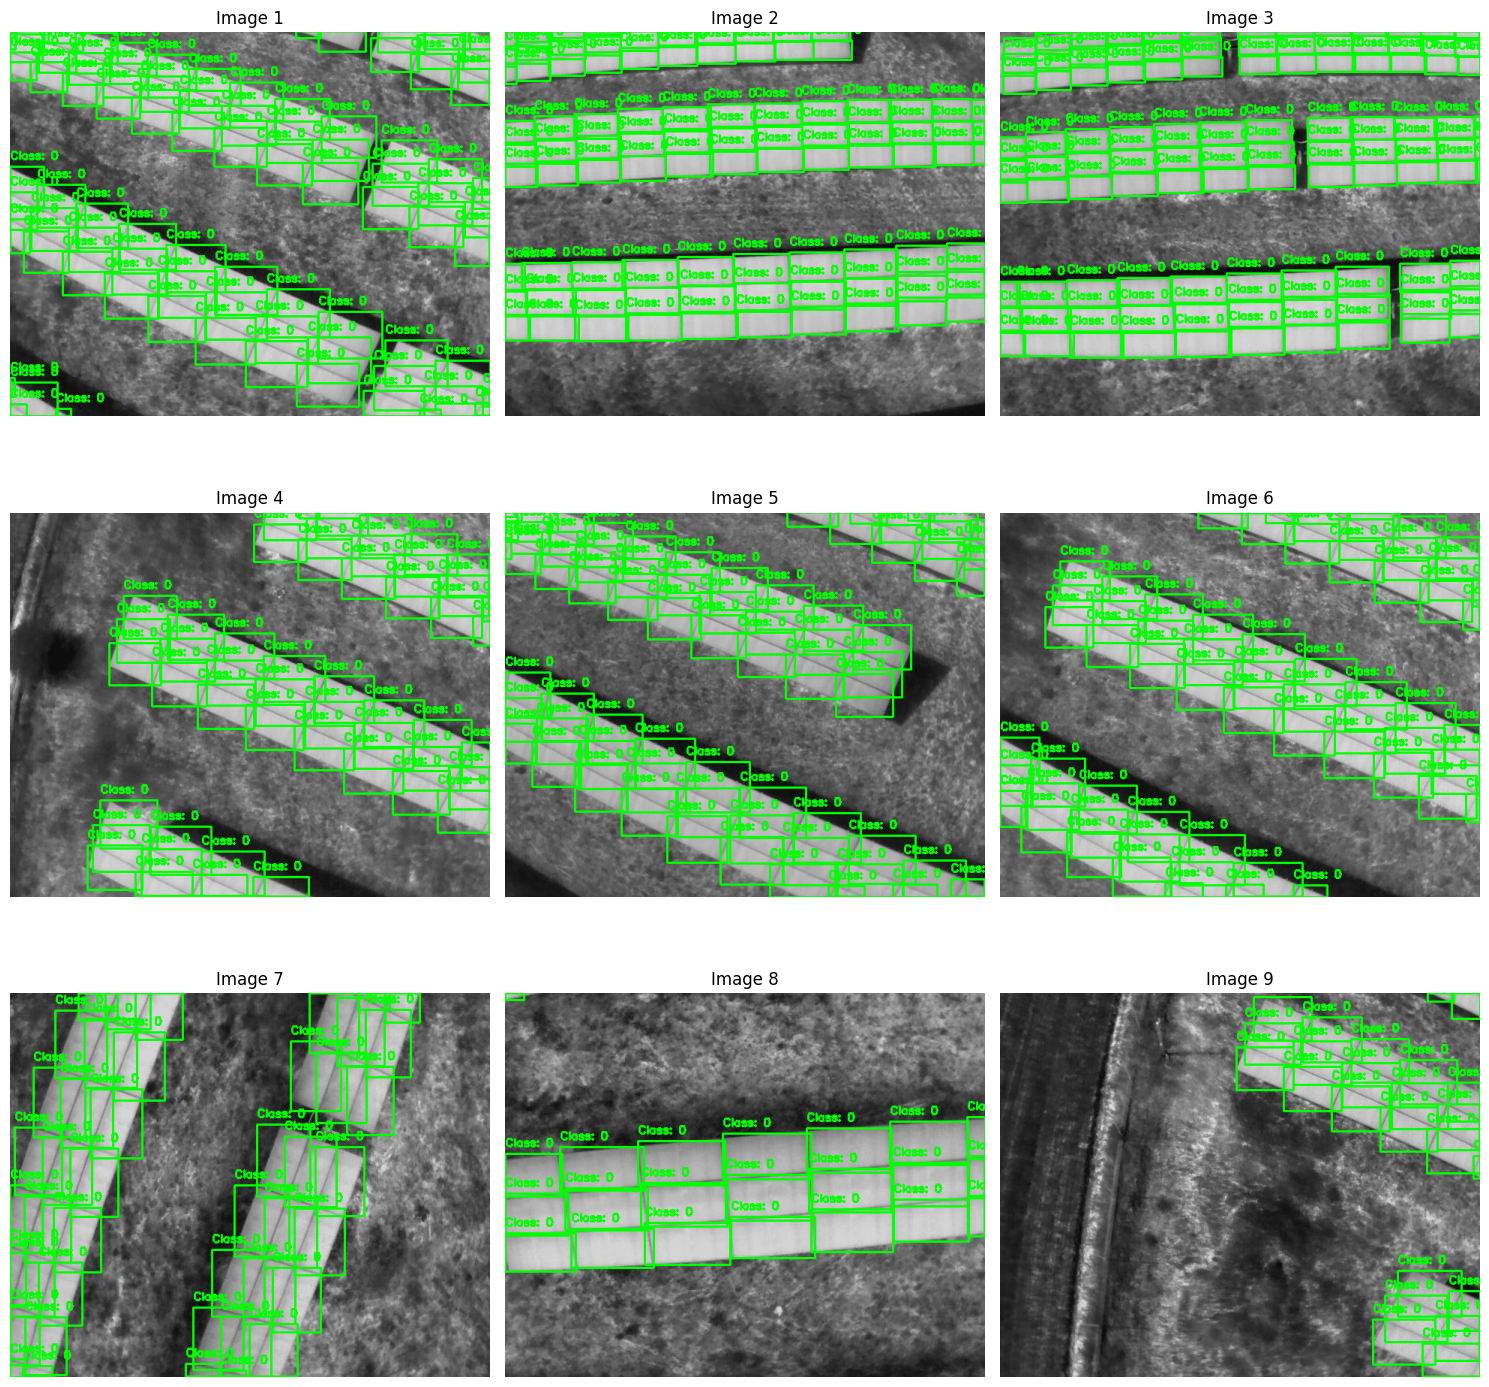

In [36]:
def display_random_images_with_annotations(base_path, num_images=6):
    """
    Displays a specified number of random images with their bounding boxes drawn.

    Args:
        base_path (Path): The base path to the dataset split (e.g., folders/"val").
        num_images (int): The number of random images to display.
    """
    images_path = list((base_path / "images").iterdir())
    labels_path = list((base_path / "labels").iterdir())

    # Asegurarse de que hay suficientes imágenes para mostrar
    num_images_to_show = min(num_images, len(images_path))

    if num_images_to_show == 0:
        print(f"No images found in {base_path / 'images'}")
        return

    # Seleccionar índices aleatorios
    selected_indices = random.sample(range(len(images_path)), num_images_to_show)

    # Configurar el subplot
    fig, axes = plt.subplots(nrows=(num_images_to_show + 2) // 3, ncols=3, figsize=(15, 5 * ((num_images_to_show + 2) // 3)))
    axes = axes.flatten() # Aplanar el array de ejes para facilitar la iteración

    print(f"\nMostrando {num_images_to_show} imágenes de {base_path.name} con sus anotaciones:")

    for i, idx in enumerate(selected_indices):
        image_path = images_path[idx]
        label_path = base_path / "labels" / f"{image_path.stem}.txt" # Construir la ruta del label

        img = cv2.imread(str(image_path))
        # Check if the image was loaded successfully
        if img is None:
            print(f"Warning: Could not load image {image_path}")
            # Hide the axis if image could not be loaded
            axes[i].axis('off')
            continue

        h, w, _ = img.shape

        if not os.path.exists(label_path):
            print(f"Label file not found for {os.path.basename(image_path)}")
            # Mostrar la imagen sin anotaciones si el label no existe
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"Image {i+1} (No Label)")
            axes[i].axis('off')
            continue

        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5: # Ensure correct number of parts
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])

                    x1 = int((x_center - width / 2) * w)
                    y1 = int((y_center - height / 2) * h)
                    x2 = int((x_center + width / 2) * w)
                    y2 = int((y_center + height / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, f"Class: {class_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                else:
                    print(f"Skipping malformed line in {label_path}: {line.strip()}")


        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(num_images_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage of the function:
display_random_images_with_annotations(folders/"val", num_images=9)

## Loading the images and lables paths in a dictionary

In [37]:
# Rutas base para los conjuntos de datos
base_path_train = folders/"train"
base_path_test = folders/"test"
base_path_val = folders/"val"

# Diccionario para almacenar las asociaciones imagen-label
image_label_mapping_train = {}
image_label_mapping_test = {}
image_label_mapping_val = {}

# Función auxiliar para poblar el diccionario
def populate_mapping(base_path, mapping_dict):
    images_path = base_path / "images"
    labels_path = base_path / "labels"

    if not images_path.exists():
        print(f"Warning: Images directory not found at {images_path}")
        return
    if not labels_path.exists():
        print(f"Warning: Labels directory not found at {labels_path}")
        return

    for image_path in images_path.iterdir():
        if image_path.suffix in ['.jpg', '.jpeg', '.png']: # Consider only image files
            label_path = labels_path / f"{image_path.stem}.txt"
            if label_path.exists():
                mapping_dict[str(image_path)] = str(label_path)
            else:
                print(f"Warning: Label file not found for {image_path.name}")

# Poblar el diccionario para cada conjunto
populate_mapping(base_path_train, image_label_mapping_train)
populate_mapping(base_path_test, image_label_mapping_test)
populate_mapping(base_path_val, image_label_mapping_val)

print(f"Diccionario image_label_mapping_train creado con {len(image_label_mapping_train)} entradas.")
print(f"Diccionario image_label_mapping_test creado con {len(image_label_mapping_test)} entradas.")
print(f"Diccionario image_label_mapping_val creado con {len(image_label_mapping_val)} entradas.")

# Puedes ver algunas entradas del diccionario para verificar
# import itertools
# for key, value in itertools.islice(image_label_mapping.items(), 10):
#     print(f"Image: {key} -> Label: {value}")

Diccionario image_label_mapping_train creado con 233 entradas.
Diccionario image_label_mapping_test creado con 35 entradas.
Diccionario image_label_mapping_val creado con 83 entradas.


## Loadding data from the eath file
Load the images and their corresponding YOLO annotation files for the training, testing, and validation sets based on the file paths stored in the `image_label_mapping_train`, `image_label_mapping_test`, and `image_label_mapping_val` dictionaries.

### Load images

Load images from the paths stored in the dictionaries for train, test, and validation sets.


The subtask requires loading images from the provided dictionaries. We will iterate through each dictionary, read the images using cv2.imread, and store them in separate lists for train, test, and validation sets.



In [38]:
# 1. Initialize empty lists
train_images = []
test_images = []
val_images = []

# 2. Load images for the training set
print("Loading training images...")
for image_path in image_label_mapping_train.keys():
    img = cv2.imread(image_path)
    if img is not None:
        train_images.append(img)
    else:
        print(f"Warning: Could not load image {image_path}")

# 3. Load images for the testing set
print("Loading testing images...")
for image_path in image_label_mapping_test.keys():
    img = cv2.imread(image_path)
    if img is not None:
        test_images.append(img)
    else:
        print(f"Warning: Could not load image {image_path}")

# 4. Load images for the validation set
print("Loading validation images...")
for image_path in image_label_mapping_val.keys():
    img = cv2.imread(image_path)
    if img is not None:
        val_images.append(img)
    else:
        print(f"Warning: Could not load image {image_path}")

print(f"Loaded {len(train_images)} training images.")
print(f"Loaded {len(test_images)} testing images.")
print(f"Loaded {len(val_images)} validation images.")

Loading training images...
Loading testing images...
Loading validation images...
Loaded 233 training images.
Loaded 35 testing images.
Loaded 83 validation images.


### Load and process labels

Load and process the YOLO format label files from the paths stored in the dictionaries for train, test, and validation sets.

Load and process the YOLO format label files for the training, testing, and validation sets based on the file paths stored in the dictionaries.

In [39]:
# 1. Initialize empty lists
train_labels = []
test_labels = []
val_labels = []

# Function to load and process labels from a mapping dictionary
def load_and_process_labels(mapping_dict):
    processed_labels = []
    for image_path, label_path in mapping_dict.items():
        image_labels = []
        try:
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        # class_id x_center y_center width height
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:])
                        image_labels.append([class_id, x_center, y_center, width, height])
                    else:
                        print(f"Skipping malformed line in {label_path}: {line.strip()}")
            processed_labels.append(image_labels)
        except FileNotFoundError:
            print(f"Warning: Label file not found for {os.path.basename(image_path)} at {label_path}")
            processed_labels.append([]) # Append empty list if label file is missing
        except Exception as e:
            print(f"Error processing label file {label_path}: {e}")
            processed_labels.append([]) # Append empty list on other errors

    return processed_labels


# 2-4. Load and process labels for the training set
print("Loading and processing training labels...")
train_labels = load_and_process_labels(image_label_mapping_train)

# 5. Load and process labels for the testing set
print("Loading and processing testing labels...")
test_labels = load_and_process_labels(image_label_mapping_test)

# 6. Load and process labels for the validation set
print("Loading and processing validation labels...")
val_labels = load_and_process_labels(image_label_mapping_val)

# 7. Print the number of loaded label files for each set
print(f"Loaded and processed labels for {len(train_labels)} training images.")
print(f"Loaded and processed labels for {len(test_labels)} testing images.")
print(f"Loaded and processed labels for {len(val_labels)} validation images.")

Loading and processing training labels...
Loading and processing testing labels...
Loading and processing validation labels...
Loaded and processed labels for 233 training images.
Loaded and processed labels for 35 testing images.
Loaded and processed labels for 83 validation images.


### Organize loaded data

Store the loaded images and processed labels in suitable data structures (e.g., lists of images and lists of corresponding labels) for each set.


### Summary:

### Data Analysis Key Findings

* The process successfully loaded 233 training images, 35 testing images, and 83 validation images.
* Corresponding YOLO format labels were loaded and processed for all images: 233 for training, 35 for testing, and 83 for validation. Each label entry includes the class ID and bounding box coordinates (x\_center, y\_center, width, height).
* The images and their respective labels were stored in separate lists for each dataset split (training, testing, and validation).


##Validation

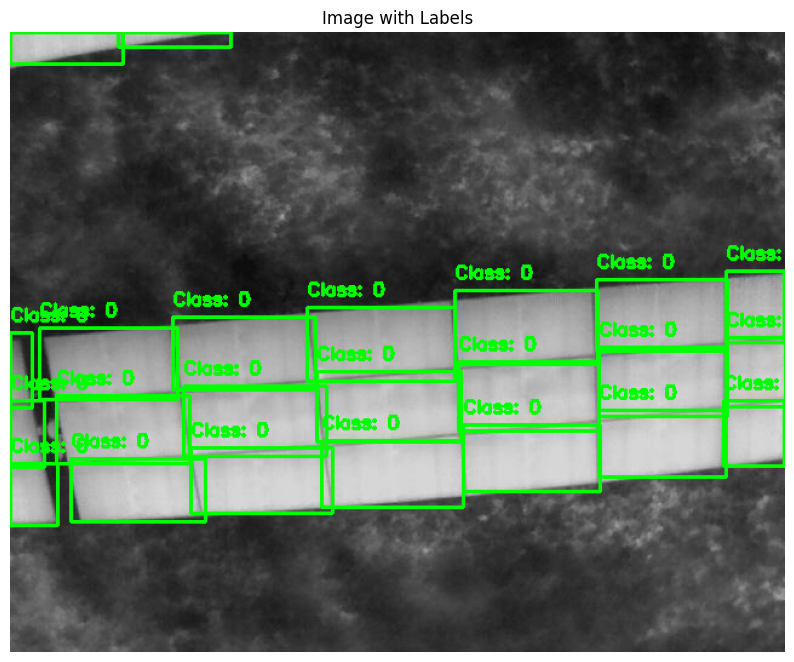

In [40]:
import matplotlib.pyplot as plt
import cv2

def visualize_image_with_labels(image, labels):
    """
    Visualizes a specific image with its bounding boxes drawn.

    Args:
        image (numpy array): The image as a numpy array.
        labels (list): A list of labels, where each element is a list of
                       [class_id, x_center, y_center, width, height] for the image.
    """
    img = image.copy() # Use a copy to avoid drawing on the original image

    h, w, _ = img.shape

    if not labels:
        print("No labels provided for this image.")
        # Display the image without annotations
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Image (No Labels)")
        plt.axis('off')
        plt.show()
        return


    for label in labels:
        if len(label) == 5:
            class_id, x_center, y_center, width, height = label

            # Convert YOLO format to pixel coordinates
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)

            # Draw rectangle
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green box
            cv2.putText(img, f"Class: {int(class_id)}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        else:
            print(f"Skipping malformed label: {label}")


    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Image with Labels")
    plt.axis('off')
    plt.show()
visualize_image_with_labels(train_images[100], train_labels[100])


In [41]:
import random
import matplotlib.pyplot as plt
import cv2

def display_random_loaded_images_with_labels(images_list, labels_list, num_images=6):
    """
    Displays a specified number of random images from loaded lists with their bounding boxes drawn in a subplot.

    Args:
        images_list (list): A list of loaded images (numpy arrays).
        labels_list (list): A list of loaded labels, where each element is a list of
                            [class_id, x_center, y_center, width, height] for the corresponding image.
        num_images (int): The number of random images to display.
    """
    if not images_list or not labels_list:
        print("Error: Image or label lists are empty.")
        return

    # Asegurarse de que hay suficientes imágenes para mostrar
    num_images_to_show = min(num_images, len(images_list))

    if num_images_to_show == 0:
        print("No images available to display.")
        return

    # Seleccionar índices aleatorios
    selected_indices = random.sample(range(len(images_list)), num_images_to_show)

    # Configurar el subplot
    # Determinar el número de filas y columnas para el subplot
    n_cols = 3
    n_rows = (num_images_to_show + n_cols - 1) // n_cols # Calcular el número de filas necesario

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() # Aplanar el array de ejes para facilitar la iteración

    print(f"\nMostrando {num_images_to_show} imágenes aleatorias con sus anotaciones:")

    for i, idx in enumerate(selected_indices):
        img = images_list[idx].copy() # Use a copy to avoid drawing on the original image
        image_labels = labels_list[idx]

        h, w, _ = img.shape

        if not image_labels:
            print(f"No labels found for image at index {idx}.")
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"Image {i+1} (No Label)")
            axes[i].axis('off')
            continue


        for label in image_labels:
            if len(label) == 5:
                class_id, x_center, y_center, width, height = label

                # Convert YOLO format to pixel coordinates
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)

                # Draw rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green box
                cv2.putText(img, f"Class: {int(class_id)}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            else:
                print(f"Skipping malformed label at index {idx}: {line.strip()}")


        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Image {i+1} (Index: {idx})")
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(num_images_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_random_loaded_images_with_labels(train_images, train_labels, num_images=9)
display_random_loaded_images_with_labels(test_images, test_labels, num_images=9)
display_random_loaded_images_with_labels(val_images, val_labels, num_images=9)

Output hidden; open in https://colab.research.google.com to view.

# 2 - Standardization and resize

In [42]:
# Definir el tamaño deseado para las imágenes
target_size = (128, 128)

# Función para redimensionar, normalizar y opcionalmente convertir a escala de grises
def preprocess_images(images_list, target_size, grayscale=False):
    """
    Redimensiona, normaliza y opcionalmente convierte una lista de imágenes a escala de grises.

    Args:
        images_list (list): Lista de imágenes (arrays de numpy).
        target_size (tuple): Tamaño deseado (ancho, alto).
        grayscale (bool): Si True, convierte las imágenes a escala de grises.

    Returns:
        list: Lista de imágenes preprocesadas.
    """
    processed_images = []
    print(f"Processing {len(images_list)} images...")
    for img in images_list:
        if img is not None:
            # Redimensionar la imagen
            resized_img = cv2.resize(img, target_size)

            # Opcionalmente convertir a escala de grises
            if grayscale and resized_img.shape[-1] == 3:
                resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
                # Añadir una dimensión para mantener el formato (height, width, 1)
                resized_img = np.expand_dims(resized_img, axis=-1)


            # Normalizar los valores de píxeles a un rango de 0 a 1
            # Asumimos que los valores originales están en el rango 0-255
            normalized_img = resized_img.astype('float32') / 255.0

            processed_images.append(normalized_img)
        else:
            print("Skipping a None image during preprocessing.")

    print("Preprocessing complete.")
    return processed_images

# Preprocesar los conjuntos de imágenes A ESCALA DE GRISES
print("\nPreprocessing training images (Grayscale)...")
train_images_processed = preprocess_images(train_images, target_size, grayscale=True)

print("\nPreprocessing testing images (Grayscale)...")
test_images_processed= preprocess_images(test_images, target_size, grayscale=True)

print("\nPreprocessing validation images (Grayscale)...")
val_images_processed = preprocess_images(val_images, target_size, grayscale=True)

print(f"\nProcessed {len(train_images_processed)} training images (Grayscale).")
print(f"Processed {len(test_images_processed)} testing images (Grayscale).")
print(f"Processed {len(val_images_processed)} validation images (Grayscale).")


if len(train_images_processed) > 0:
    print(f"Shape of a processed training image (Grayscale): {train_images_processed[0].shape}")
    print(f"Data type of a processed training image (Grayscale): {train_images_processed[0].dtype}")


Preprocessing training images (Grayscale)...
Processing 233 images...
Preprocessing complete.

Preprocessing testing images (Grayscale)...
Processing 35 images...
Preprocessing complete.

Preprocessing validation images (Grayscale)...
Processing 83 images...
Preprocessing complete.

Processed 233 training images (Grayscale).
Processed 35 testing images (Grayscale).
Processed 83 validation images (Grayscale).
Shape of a processed training image (Grayscale): (128, 128, 1)
Data type of a processed training image (Grayscale): float32


In [43]:
# Definir el tamaño objetivo (debe coincidir con el tamaño al que redimensionaste las imágenes)
target_width, target_height = target_size # target_size should be defined from previous steps

# Función para adaptar las etiquetas al nuevo tamaño de imagen
def adapt_labels_to_size(labels_list, target_width, target_height):
    """
    Adapts YOLO formatted labels (normalized) to pixel coordinates for a target size.

    Args:
        labels_list (list): A list of label lists, where each inner list contains
                            [class_id, x_center, y_center, width, height] for an image.
        target_width (int): The target width of the image in pixels.
        target_height (int): The target height of the image in pixels.

    Returns:
        list: A list of label lists, where each inner list contains
              [class_id, x1, y1, x2, y2] in pixel coordinates for the target size.
    """
    adapted_labels = []
    print(f"Adapting labels for {len(labels_list)} images...")

    for image_labels in labels_list:
        image_adapted_labels = []
        for label in image_labels:
            if len(label) == 5:
                class_id, x_center, y_center, width, height = label

                # Convert normalized YOLO format to pixel coordinates (x1, y1, x2, y2)
                x_center_abs = x_center * target_width
                y_center_abs = y_center * target_height
                width_abs = width * target_width
                height_abs = height * target_height

                x1 = int(x_center_abs - width_abs / 2)
                y1 = int(y_center_abs - height_abs / 2)
                x2 = int(x_center_abs + width_abs / 2)
                y2 = int(y_center_abs + height_abs / 2)

                # Ensure coordinates are within bounds (optional but good practice)
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(target_width - 1, x2)
                y2 = min(target_height - 1, y2)


                image_adapted_labels.append([int(class_id), x1, y1, x2, y2])
            else:
                # Handle malformed labels if necessary
                print(f"Skipping malformed label: {label}")
        adapted_labels.append(image_adapted_labels)

    print("Label adaptation complete.")
    return adapted_labels

# Adaptar los labels para cada conjunto
if 'train_labels' in locals():
    print("Adapting training labels...")
    train_labels_adapted = adapt_labels_to_size(train_labels, target_width, target_height)
    print(f"Adapted labels for {len(train_labels_adapted)} training images.")
else:
    print("train_labels not found. Skipping adaptation for training set.")

if 'test_labels' in locals():
    print("\nAdapting testing labels...")
    test_labels_adapted = adapt_labels_to_size(test_labels, target_width, target_height)
    print(f"Adapted labels for {len(test_labels_adapted)} testing images.")
else:
    print("test_labels not found. Skipping adaptation for testing set.")

if 'val_labels' in locals():
    print("\nAdapting validation labels...")
    val_labels_adapted = adapt_labels_to_size(val_labels, target_width, target_height)
    print(f"Adapted labels for {len(val_labels_adapted)} validation images.")
else:
     print("val_labels not found. Skipping adaptation for validation set.")

# Opcional: verificar las etiquetas adaptadas para una imagen
# if 'train_labels_adapted' in locals() and len(train_labels_adapted) > 0:
#     print("\nExample adapted training labels for the first image:")
#     print(train_labels_adapted[0])

Adapting training labels...
Adapting labels for 233 images...
Label adaptation complete.
Adapted labels for 233 training images.

Adapting testing labels...
Adapting labels for 35 images...
Label adaptation complete.
Adapted labels for 35 testing images.

Adapting validation labels...
Adapting labels for 83 images...
Label adaptation complete.
Adapted labels for 83 validation images.


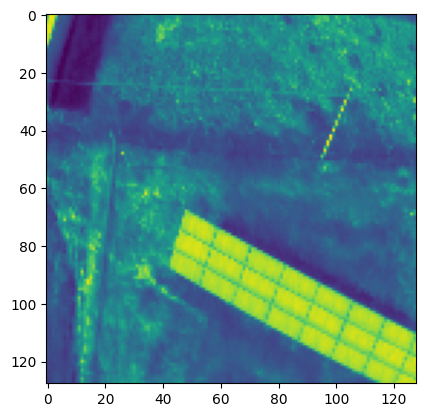

In [44]:
plt.imshow(train_images_processed[0])

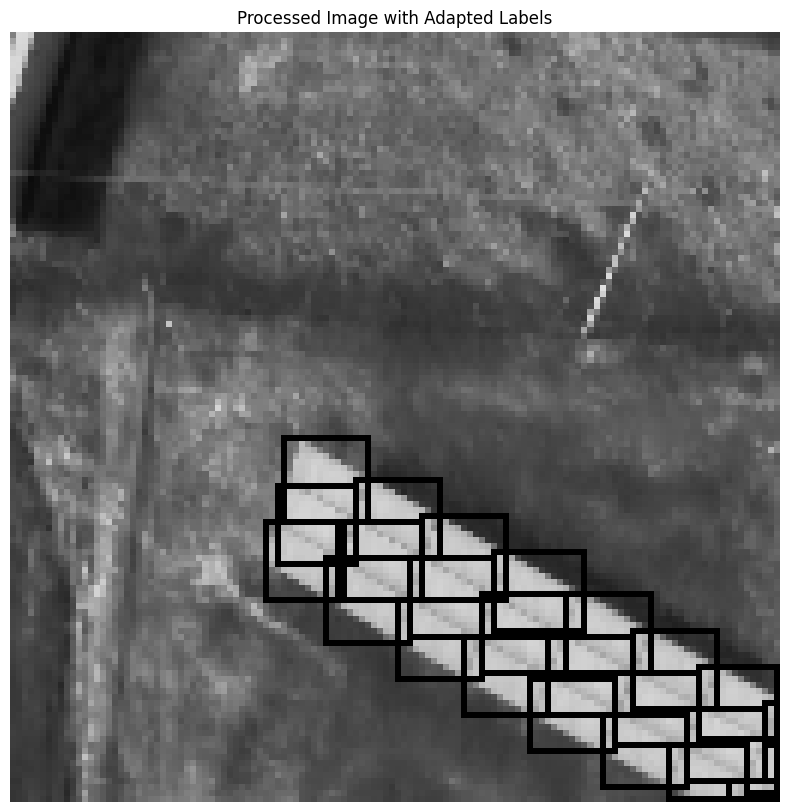

In [45]:
import matplotlib.pyplot as plt
import cv2
import numpy as np # Import numpy

def visualize_processed_image_with_adapted_labels(image_processed, labels_adapted):
    """
    Visualizes a single processed image with its adapted bounding boxes drawn.
    Assumes image_processed is a numpy array (float32, range 0-1) and
    labels_adapted are in pixel coordinates [class_id, x1, y1, x2, y2].

    Args:
        image_processed (numpy array): The preprocessed image (float32, range 0-1).
        labels_adapted (list): A list of adapted labels, where each element is a list of
                               [class_id, x1, y1, x2, y2] in pixel coordinates.
    """
    # Convert the processed image (float32, 0-1) to uint8 (0-255) for drawing
    # Keep a copy for display
    img_display = (image_processed * 255).astype('uint8').copy()

    h, w, _ = img_display.shape # Get dimensions from the processed image

    if not labels_adapted:
        print("No labels provided for this image.")
        # Display the original processed image (normalized)
        plt.figure(figsize=(10, 10))
        plt.imshow(image_processed) # Display the normalized image
        plt.title("Processed Image (No Labels)")
        plt.axis('off')
        plt.show()
        return


    for label in labels_adapted:
        # Expecting format [class_id, x1, y1, x2, y2]
        if len(label) == 5:
            class_id, x1, y1, x2, y2 = label

            # Ensure coordinates are integers for drawing
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)


            # Draw rectangle using pixel coordinates on the uint8 image
            cv2.rectangle(img_display, (x1, y1), (x2, y2), (0, 255, 0), 1) # Green box, thickness changed to 1
            #cv2.putText(img_display, f"Class: {int(class_id)}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        else:
            print(f"Skipping malformed label: {label}")


    # Display the image with drawn bounding boxes
    # Convert back to RGB for matplotlib display if necessary (cv2 reads BGR)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image with Adapted Labels")
    plt.axis('off')
    plt.show()


visualize_processed_image_with_adapted_labels(train_images_processed[0], train_labels_adapted[0])



Mostrando 9 imágenes preprocesadas aleatorias con sus anotaciones adaptadas:


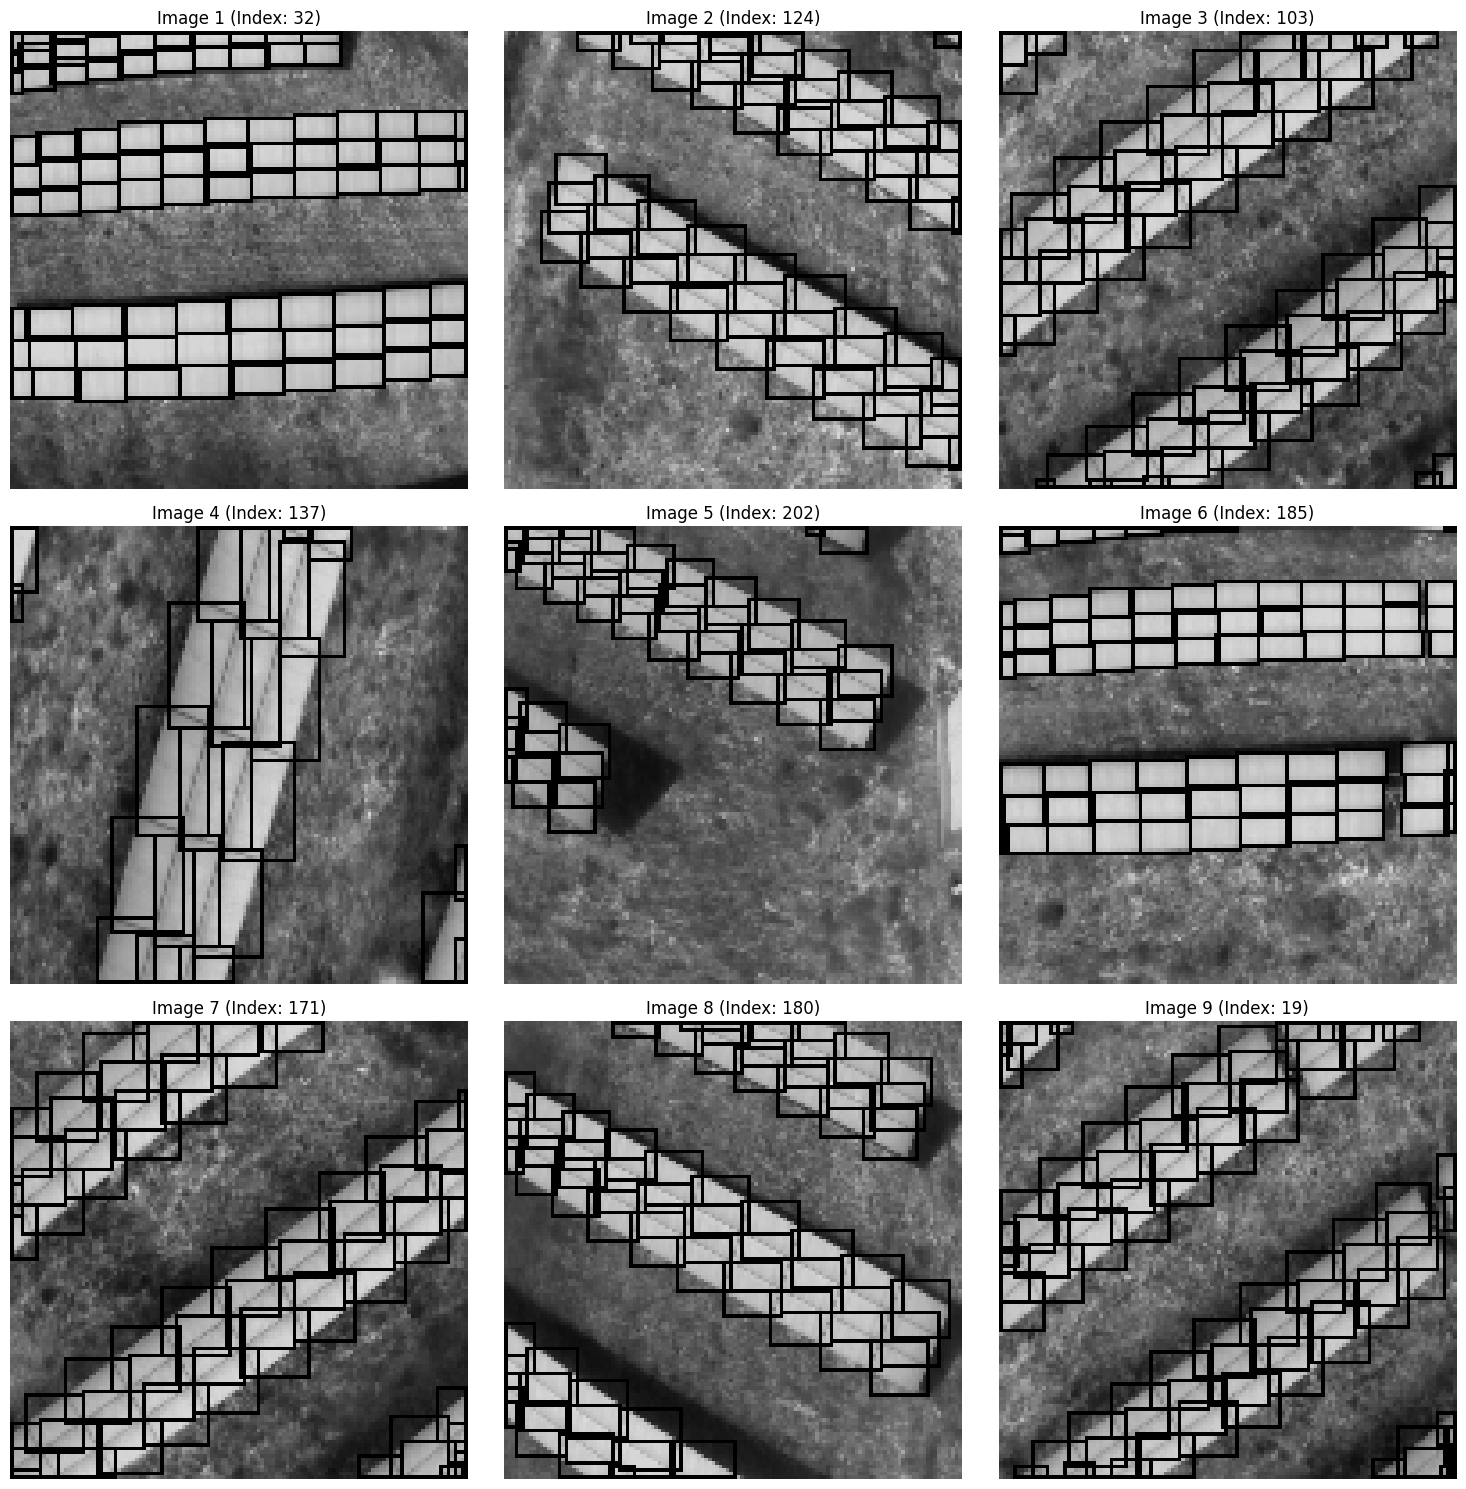


Mostrando 9 imágenes preprocesadas aleatorias con sus anotaciones adaptadas:


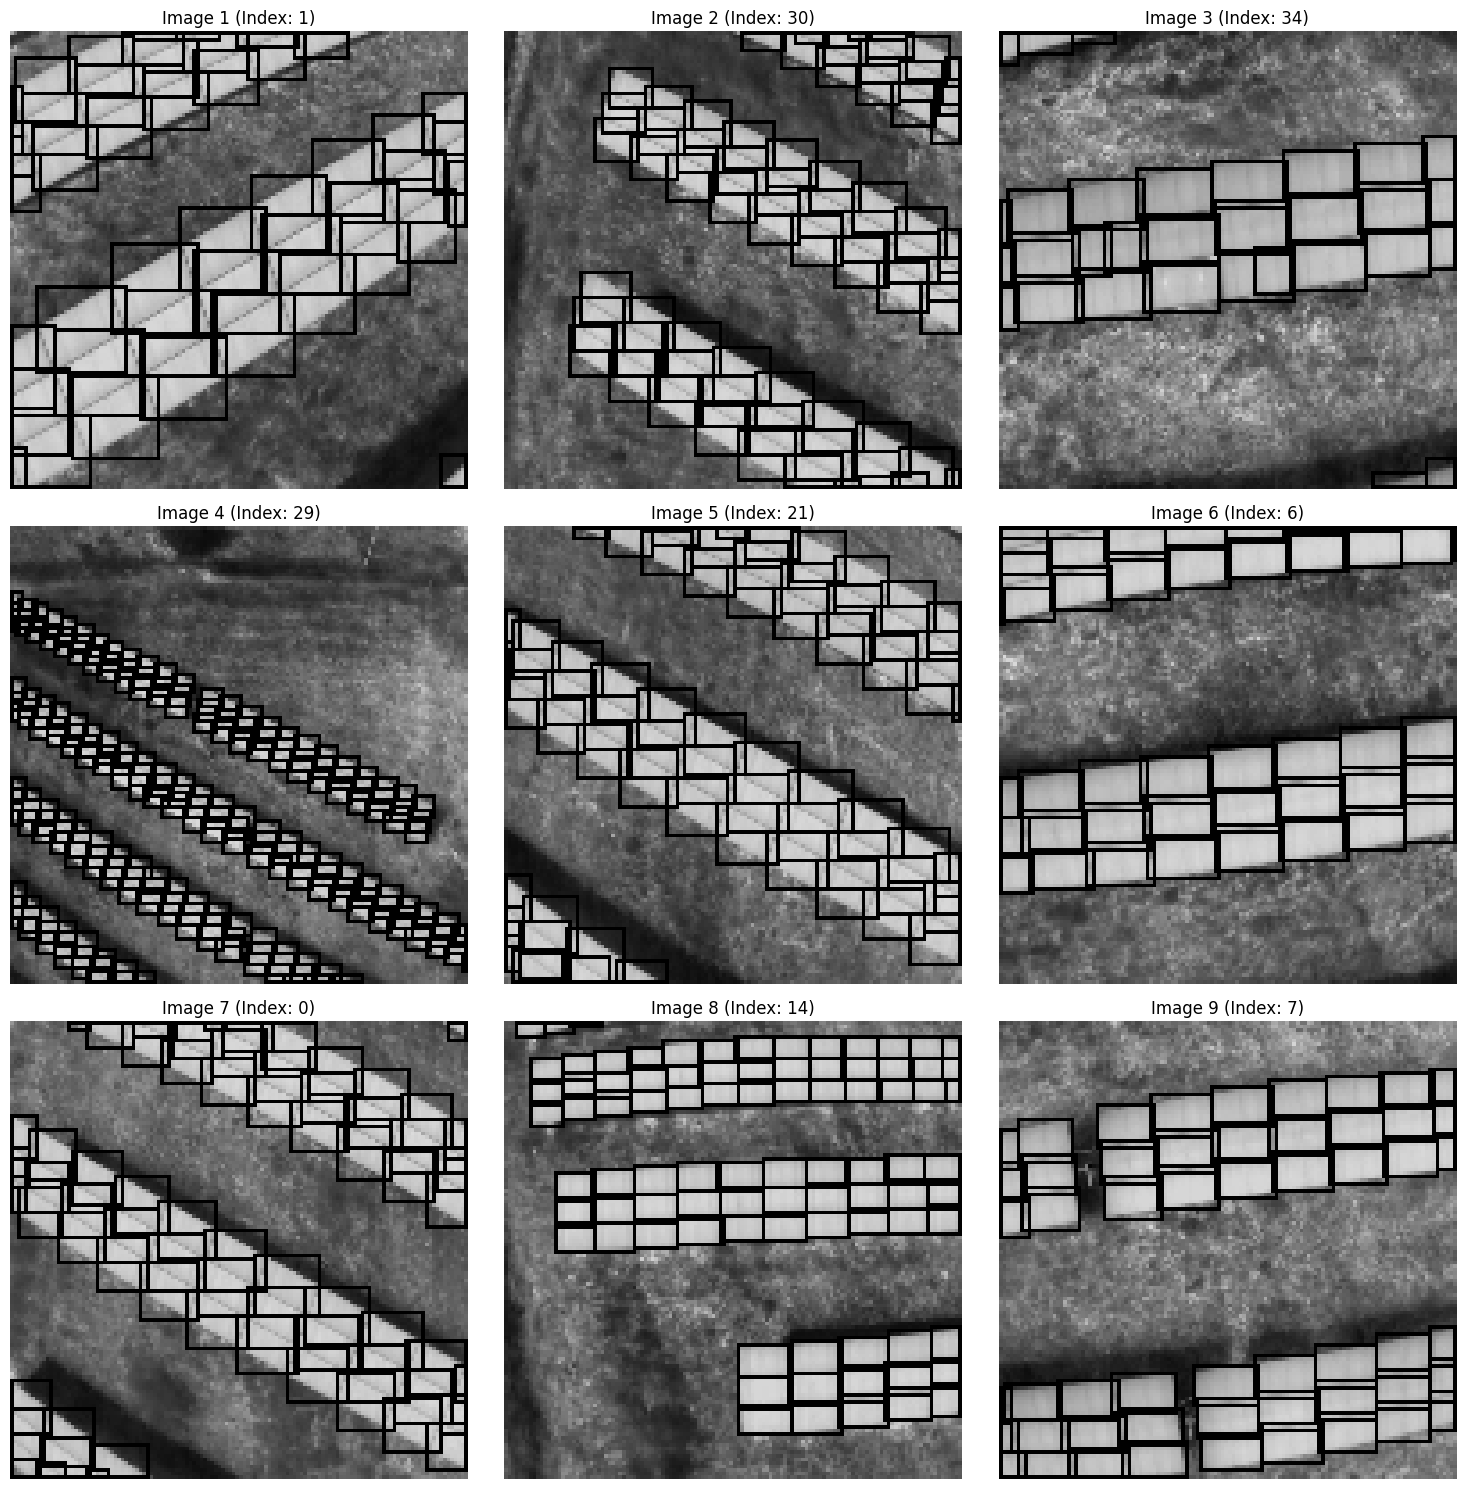


Mostrando 9 imágenes preprocesadas aleatorias con sus anotaciones adaptadas:


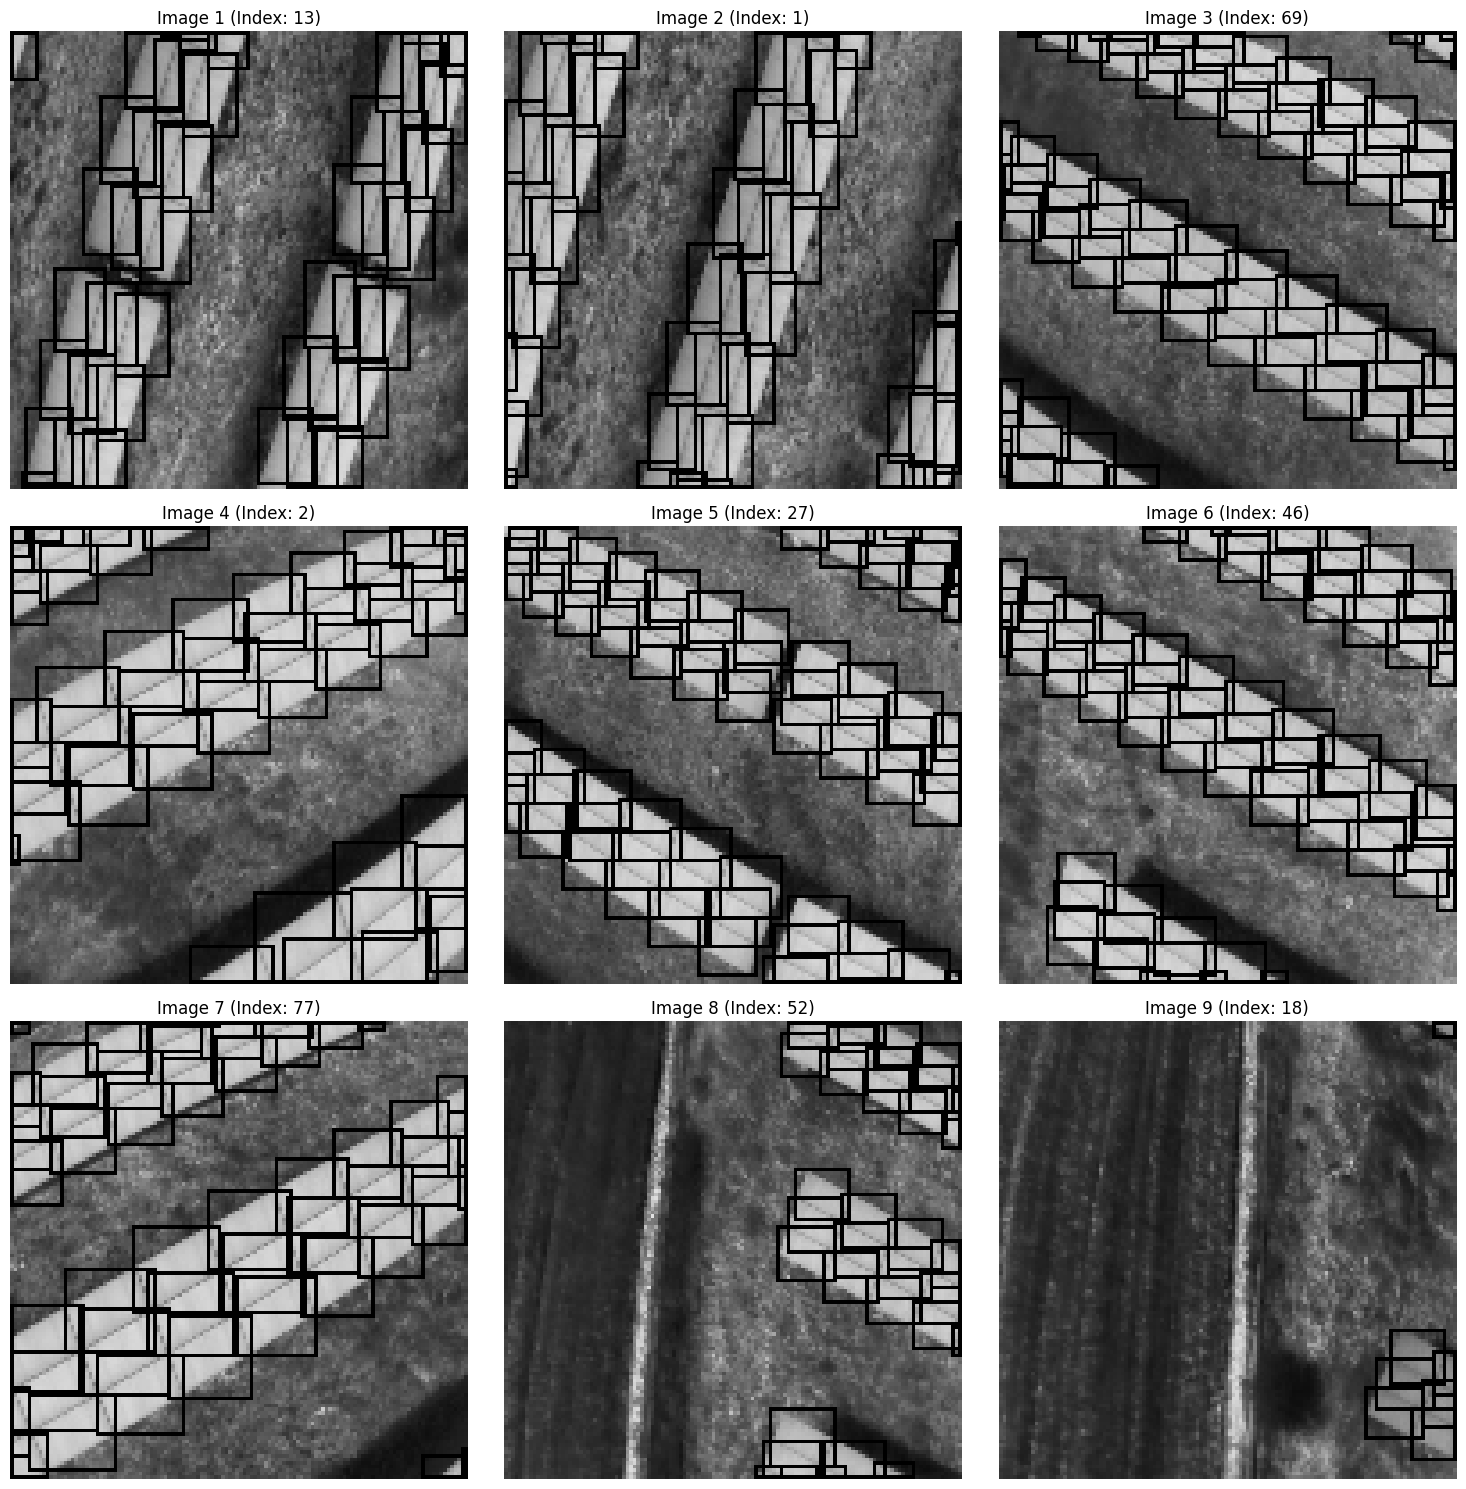

In [46]:
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np # Import numpy

def display_random_processed_images_with_adapted_labels(images_processed_list, labels_adapted_list, num_images=6):
    """
    Displays a specified number of random processed images with their adapted bounding boxes drawn in a subplot.
    Assumes images_processed_list contains numpy arrays (float32, range 0-1) and
    labels_adapted_list contains labels in pixel coordinates [class_id, x1, y1, x2, y2].

    Args:
        images_processed_list (list): A list of processed images (numpy arrays, float32, range 0-1).
        labels_adapted_list (list): A list of adapted labels, where each element is a list of
                               [class_id, x1, y1, x2, y2] in pixel coordinates for the corresponding image size.
        num_images (int): The number of random images to display.
    """
    if not images_processed_list or not labels_adapted_list:
        print("Error: Processed image or adapted label lists are empty.")
        return
    if len(images_processed_list) != len(labels_adapted_list):
         print("Warning: Number of processed images and adapted labels do not match.")


    # Asegurarse de que hay suficientes imágenes para mostrar
    num_images_to_show = min(num_images, len(images_processed_list))

    if num_images_to_show == 0:
        print("No processed images available to display.")
        return

    # Seleccionar índices aleatorios
    selected_indices = random.sample(range(len(images_processed_list)), num_images_to_show)

    # Configurar el subplot
    # Determinar el número de filas y columnas para el subplot
    n_cols = 3
    n_rows = (num_images_to_show + n_cols - 1) // n_cols # Calcular el número de filas necesario

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() # Aplanar el array de ejes para facilitar la iteración

    print(f"\nMostrando {num_images_to_show} imágenes preprocesadas aleatorias con sus anotaciones adaptadas:")

    for i, idx in enumerate(selected_indices):
        # We expect processed images (float32, range 0-1), but OpenCV drawing functions
        # work best with uint8 images (range 0-255). Convert for drawing, but
        # display the normalized image.
        img_processed = images_processed_list[idx]
        img_display = (img_processed * 255).astype('uint8').copy()


        image_adapted_labels = labels_adapted_list[idx]

        # Get dimensions from the image itself as it's already resized
        h, w, _ = img_display.shape

        if not image_adapted_labels:
            print(f"No adapted labels found for image at index {idx}.")
            # Display the normalized image
            axes[i].imshow(img_processed)
            axes[i].set_title(f"Image {i+1} (Index: {idx}, No Label)")
            axes[i].axis('off')
            continue


        for label in image_adapted_labels:
            # Expecting format [class_id, x1, y1, x2, y2]
            if len(label) == 5:
                class_id, x1, y1, x2, y2 = label

                # Ensure coordinates are integers for drawing
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)


                # Draw rectangle using pixel coordinates on the uint8 image
                cv2.rectangle(img_display, (x1, y1), (x2, y2), (0, 255, 0), 1) # Green box, thickness set to 1
                #cv2.putText(img_display, f"Class: {int(class_id)}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            else:
                print(f"Skipping malformed label at index {idx}: {label}")


        # Display the image with drawn bounding boxes
        # Convert back to RGB for matplotlib display
        axes[i].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Image {i+1} (Index: {idx})")
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(num_images_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_random_processed_images_with_adapted_labels(train_images_processed, train_labels_adapted, num_images=9)
display_random_processed_images_with_adapted_labels(test_images_processed, test_labels_adapted, num_images=9)
display_random_processed_images_with_adapted_labels(val_images_processed, val_labels_adapted, num_images=9)

# 3 - First Model

In [47]:
import tensorflow as tf
import numpy as np

# Convertir las listas de imágenes a arrays de NumPy
train_images_np = np.array(train_images_processed)
test_images_np = np.array(test_images_processed)
val_images_np = np.array(val_images_processed)

# The labels_adapted lists already contain the bounding box coordinates in pixel format [class_id, x1, y1, x2, y2]
# For object detection, we need to provide these coordinates as the target output.
# We'll keep the labels as lists of lists, where each inner list is a bounding box.
# We will need to pad these labels later if we use batching with tf.data,
# as tensors in a batch must have consistent shapes. However, for now,
# we can create the dataset with ragged tensors if needed, or handle padding
# during the model training/loss calculation.

# For a simple model outputting a fixed number of boxes (e.g., 1 box per image assumption,
# or padding to a max number of boxes), we might need to further process labels.
# However, let's first create a dataset where the labels are the lists of bounding boxes.

# Define the expected shape of the image for object detection
image_shape = (128, 128, 1) # Grayscale images (1 channel)
# The label shape will be variable depending on the number of objects detected per image.

# Crear tf.data.Dataset para detección de objetos
# We will use from_generator for labels since the number of bounding boxes per image is variable.
# This requires a slightly different approach than from_tensor_slices for the labels.

# Let's reconsider the model architecture. A common approach for simple object detection
# is to predict a fixed number of bounding boxes and their confidence scores.
# Alternatively, for a simple model predicting a single bounding box per image (assuming
# the primary object is the panel), we could adapt the labels to predict just one box.

# Given the user's goal is to generate *the* bounding boxes where panels are,
# and there can be multiple panels per image, a simple regression model
# predicting a fixed set of box coordinates might not be ideal.

# Let's create a dataset that pairs images with their list of bounding box labels.
# We will need to handle the variable number of labels per image during training.

# Option 1: Use tf.ragged.RaggedTensor for labels (handles variable lengths)
# This is a flexible approach for variable numbers of bounding boxes.
# However, it adds complexity to the model and loss function.

# Option 2: Pad the labels to a fixed size.
# This requires knowing the maximum number of bounding boxes per image or setting a reasonable maximum.
# Let's inspect the maximum number of bounding boxes in the dataset to inform padding.

# Function to find the maximum number of bounding boxes
def max_boxes_per_image(labels_list):
    max_boxes = 0
    for image_labels in labels_list:
        max_boxes = max(max_boxes, len(image_labels))
    return max_boxes

max_train_boxes = max_boxes_per_image(train_labels_adapted)
max_test_boxes = max_boxes_per_image(test_labels_adapted)
max_val_boxes = max_boxes_per_image(val_labels_adapted)

max_total_boxes = max(max_train_boxes, max_test_boxes, max_val_boxes)
print(f"Maximum number of bounding boxes per image in the dataset: {max_total_boxes}")

# Let's pad the labels to this maximum number. Each padded label entry will be [class_id, x1, y1, x2, y2].
# We'll use a padding value (e.g., -1) to indicate a padded entry.

"""The pad_labels function in cell is used to ensure that all the label arrays have the same dimension,
specifically the dimension of the array with the maximum number of bounding boxes detected.
Padding makes them uniform in size.
By padding the labels to the max_total_boxes (which is 584 in this case),
we are indeed limiting the model to predict a maximum of 584 bounding boxes or panel per image."""

def pad_labels(labels_list, max_boxes, padding_value=-1):
    padded_labels = []
    for image_labels in labels_list:
        # Pad with dummy entries [padding_value, padding_value, padding_value, padding_value, padding_value]
        num_padding = max_boxes - len(image_labels)
        padded_image_labels = image_labels + [[padding_value] * 5] * num_padding
        padded_labels.append(padded_image_labels)
    return np.array(padded_labels, dtype=np.float32) # Use float32 as coordinates are floats

train_labels_padded = pad_labels(train_labels_adapted, max_total_boxes)
test_labels_padded = pad_labels(test_labels_adapted, max_total_boxes)
val_labels_padded = pad_labels(val_labels_adapted, max_total_boxes)

print(f"Shape of padded training labels: {train_labels_padded.shape}")
print(f"Shape of padded testing labels: {test_labels_padded.shape}")
print(f"Shape of padded validation labels: {val_labels_padded.shape}")

# Now create tf.data.Dataset using the padded labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_np, train_labels_padded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_np, test_labels_padded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images_np, val_labels_padded))

print("\nDatasets de TensorFlow para detección de objetos creados:")
print(f"  Train Dataset: {train_dataset.element_spec}") # Print element_spec to verify shape
print(f"  Test Dataset: {test_dataset.element_spec}")
print(f"  Val Dataset: {val_dataset.element_spec}")

# Opcional: verificar un elemento del dataset
for image, labels in train_dataset.take(1):
    print("\nEjemplo de un elemento del dataset de entrenamiento:")
    print("Imagen (shape, dtype):", image.shape, image.dtype)
    print("Labels (shape, dtype):", labels.shape, labels.dtype)
    print("Contenido de labels:", labels.numpy())

Maximum number of bounding boxes per image in the dataset: 584
Shape of padded training labels: (233, 584, 5)
Shape of padded testing labels: (35, 584, 5)
Shape of padded validation labels: (83, 584, 5)

Datasets de TensorFlow para detección de objetos creados:
  Train Dataset: (TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(584, 5), dtype=tf.float32, name=None))
  Test Dataset: (TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(584, 5), dtype=tf.float32, name=None))
  Val Dataset: (TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(584, 5), dtype=tf.float32, name=None))

Ejemplo de un elemento del dataset de entrenamiento:
Imagen (shape, dtype): (128, 128, 1) <dtype: 'float32'>
Labels (shape, dtype): (584, 5) <dtype: 'float32'>
Contenido de labels: [[  0.  42.  81.  55.  94.]
 [  0. 100. 106. 114. 118.]
 [  0. 109. 118. 122. 127.]
 ...
 [ -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.]
 [ 

## Modelo con una única capa convolucional

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D

# 2. Construir un modelo con una única capa convolucional
input_shape = (128, 128, 1)
inputs = Input(shape=input_shape)

# Esta es la única capa que nos interesa. Le ponemos un nombre para identificarla.
# Usaremos 16 "filtros" o "kernels". Cada filtro buscará un patrón diferente.
conv_layer = Conv2D(
    filters=16,
    kernel_size=(3, 3),
    activation='relu',
    name='capa_convolucional'
)(inputs)

# El modelo termina aquí. La salida es el resultado directo de la capa convolucional.
visualization_model = Model(inputs=inputs, outputs=conv_layer)

print("\n✅ Modelo de visualización construido:")
visualization_model.summary()


✅ Modelo de visualización construido:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_convolucional (Conv2D)     │ (None, 126, 126, 16)   │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160 (640.00 B)

 Trainable params: 160 (640.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step

Forma del mapa de características de salida: (1, 126, 126, 16)


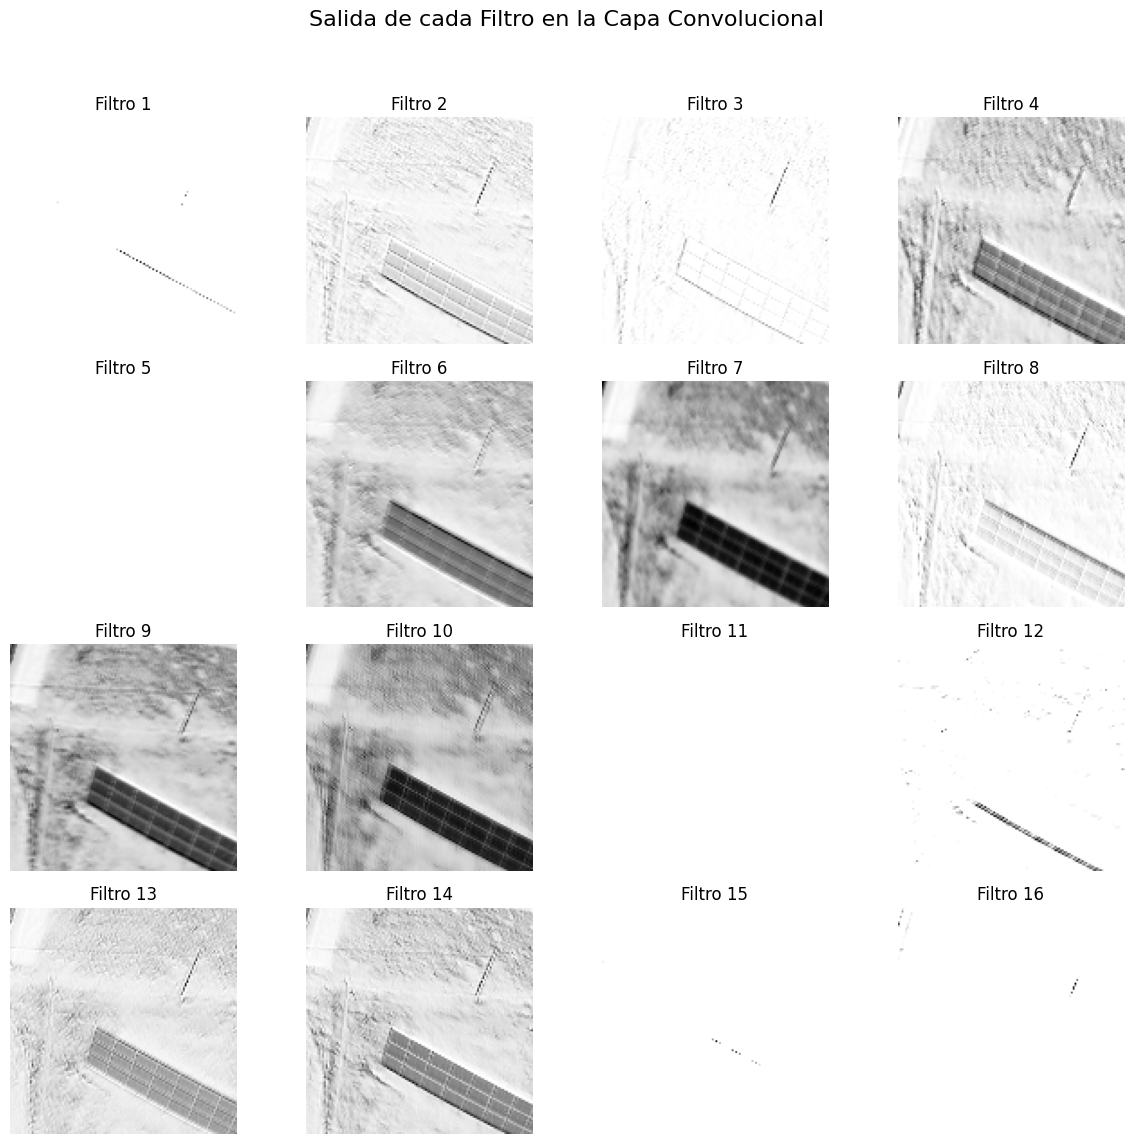

In [49]:
# 3. Preparar la imagen y obtener el mapa de características
# El método .predict() espera un lote (batch) de imágenes.
# Nuestra imagen tiene forma (128, 128, 1), necesitamos añadirle una dimensión de lote -> (1, 128, 128, 1)
image_batch = tf.expand_dims(image, axis=0)

# Obtenemos la salida de la capa convolucional
feature_maps = visualization_model.predict(image_batch)
print(f"\nForma del mapa de características de salida: {feature_maps.shape}")
# La forma será (1, alto, ancho, 16) -> (batch, altura, anchura, número de filtros)

# 4. Visualizar los mapas de características
# Quitamos la dimensión del lote para poder manejar los datos más fácil
feature_maps = feature_maps[0]

num_filters = feature_maps.shape[-1]
# Creamos una grilla para mostrar la salida de cada uno de los 16 filtros
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Salida de cada Filtro en la Capa Convolucional', fontsize=16)

for i in range(num_filters):
    ax = axes[i // 4, i % 4]
    # Cada canal del feature_maps corresponde a la salida de un filtro
    ax.imshow(feature_maps[:, :, i], "Grays")
    ax.set_title(f'Filtro {i+1}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Preparacion por lotes

In [50]:
# Definimos un tamaño de lote. 32 o 64 son valores comunes.
BATCH_SIZE = 32

# Creamos un nuevo dataset en lotes. Omitimos las etiquetas con (_, ) ya que no las usaremos aquí.
train_dataset_batched = train_dataset.batch(BATCH_SIZE)

num_filters = 16
# El tamaño del kernel que definimos en la capa Conv2D
kernel_size = 3

# Arrays para guardar la máxima activación y el parche correspondiente para cada filtro
# Inicializamos con ceros.
max_activations = np.zeros(num_filters)
# Guardará los 16 parches de 3x3 que buscamos.
best_patches = np.zeros((num_filters, kernel_size, kernel_size, 1))

print("🔥 Procesando todo el dataset para encontrar los patrones óptimos...")

# Iterar sobre cada lote (batch) del dataset de entrenamiento
for images_batch, _ in train_dataset_batched:

    # Obtenemos los mapas de características para el lote actual
    # 'verbose=0' es para que no imprima el progreso en cada paso
    feature_maps_batch = visualization_model.predict(images_batch, verbose=0)

    # Ahora, para cada filtro, buscamos su activación máxima dentro de este lote
    for filter_idx in range(num_filters):
        # Encontrar la activación máxima para este filtro en todo el lote
        max_activation_in_batch = np.max(feature_maps_batch[:, :, :, filter_idx])

        # Si esta activación es la más alta que hemos visto hasta ahora para este filtro...
        if max_activation_in_batch > max_activations[filter_idx]:
            # 1. Actualizamos el nuevo valor máximo
            max_activations[filter_idx] = max_activation_in_batch

            # 2. Encontramos las coordenadas (imagen, fila, columna) de esa activación máxima
            coords = np.unravel_index(np.argmax(feature_maps_batch[:, :, :, filter_idx]), feature_maps_batch[:, :, :, filter_idx].shape)
            img_idx_in_batch, row, col = coords

            # 3. Extraemos el parche 3x3 de la IMAGEN DE ENTRADA original que causó esta activación
            patch = images_batch[img_idx_in_batch, row : row + kernel_size, col : col + kernel_size, :]
            best_patches[filter_idx] = patch

print("✅ Análisis completado.")

🔥 Procesando todo el dataset para encontrar los patrones óptimos...
✅ Análisis completado.


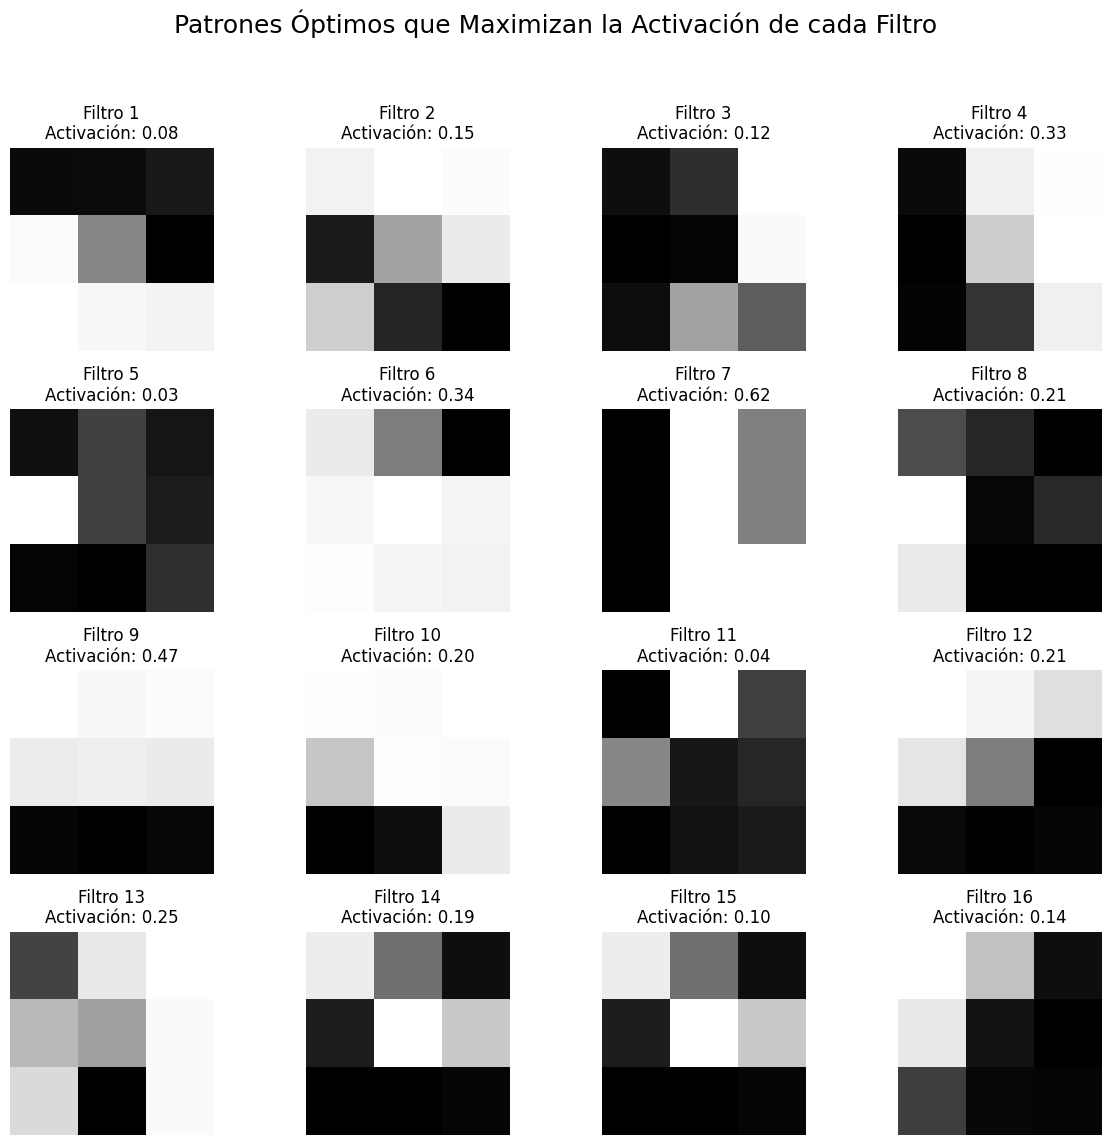

In [51]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Patrones Óptimos que Maximizan la Activación de cada Filtro', fontsize=18)

for i in range(num_filters):
    ax = axes[i // 4, i % 4]

    # Mostramos el parche de 3x3 que más activó al filtro
    # 'interpolation="nearest"' es para que los píxeles se vean nítidos y no borrosos
    ax.imshow(best_patches[i, :, :, 0], cmap='gray', interpolation='nearest')
    ax.set_title(f'Filtro {i+1}\nActivación: {max_activations[i]:.2f}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Paso 1: BACKBONE convolutional complet

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D

def construir_backbone(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)

    # Bloque 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    # Bloque 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Bloque 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x) # La salida aquí será un mapa de características rico en información.

    # Creamos un modelo solo con el backbone por ahora
    backbone_model = Model(inputs=inputs, outputs=x)
    return backbone_model

backbone = construir_backbone()
print("🧱 Backbone del modelo construido:")
backbone.summary()

🧱 Backbone del modelo construido:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,672 (362.00 KB)

 Trainable params: 92,672 (362.00 KB)

 Non-trainable params: 0 (0.00 B)

--- Nuestro Sujeto de Pruebas ---
Forma de la imagen de muestra: (128, 128, 1)
Forma de la etiqueta de muestra: (584, 5)


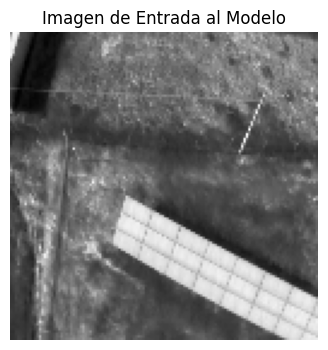

In [53]:
# Suponiendo que 'train_dataset' es tu dataset original con padding
# Tomamos una sola imagen y su etiqueta.
for image, label in train_dataset.take(1):
    sample_image = image
    sample_label = label
    break

print("--- Nuestro Sujeto de Pruebas ---")
print(f"Forma de la imagen de muestra: {sample_image.shape}")
print(f"Forma de la etiqueta de muestra: {sample_label.shape}")

# Vamos a visualizar la imagen que vamos a usar
plt.figure(figsize=(4, 4))
plt.imshow(sample_image[:, :, 0], cmap='gray') # Usamos [:, :, 0] para quitar la dimensión del canal
plt.title("Imagen de Entrada al Modelo")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
--- Salida del Backbone para una Imagen ---
Forma del mapa de características: (1, 16, 16, 128)


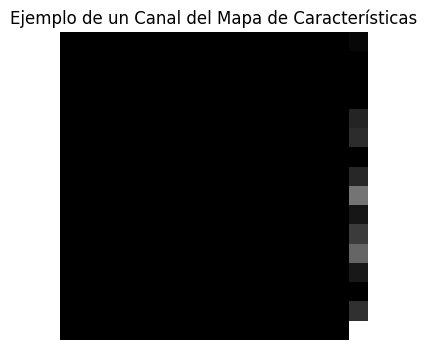

In [54]:
backbone = construir_backbone()

# Añadimos la dimensión de lote a nuestra imagen de muestra
image_batch = tf.expand_dims(sample_image, axis=0)

# Obtenemos el mapa de características para nuestra imagen
feature_map_sample = backbone.predict(image_batch)

print("--- Salida del Backbone para una Imagen ---")
print(f"Forma del mapa de características: {feature_map_sample.shape}")

# Visualicemos una de las 128 características extraídas
plt.figure(figsize=(4, 4))
plt.imshow(feature_map_sample[0, :, :, 0], cmap='gray')
plt.title("Ejemplo de un Canal del Mapa de Características")
plt.axis('off')
plt.show()

In [55]:
"""
 La salida ya no parece una imagen, sino un conjunto de "activaciones"
 que indican dónde el modelo encontró características complejas.
 La forma (1, 16, 16, 128) significa que tenemos un mapa de 16x16 con
 128 canales o características distintas.
"""

'\n La salida ya no parece una imagen, sino un conjunto de "activaciones"\n que indican dónde el modelo encontró características complejas.\n La forma (1, 16, 16, 128) significa que tenemos un mapa de 16x16 con\n 128 canales o características distintas.\n'

## Paso 2: Backbone + Dense layers

In [56]:
from tensorflow.keras.layers import Flatten, Dense

# Obtenemos la última capa del backbone que construimos
backbone_output = backbone.output

# Aplanamos el mapa de características 2D a un vector 1D
x = Flatten()(backbone_output)
x = Dense(128, activation='relu')(x)

# Cabeza de Clasificación: Predice la probabilidad de que haya un objeto.
output_clase = Dense(1, activation='sigmoid', name='output_clase')(x)

# Cabeza de Regresión: Predice las 4 coordenadas de la caja.
output_caja = Dense(4, activation='sigmoid', name='output_caja')(x)

# Unimos todo en el modelo final
modelo_completo = Model(inputs=backbone.input, outputs=[output_clase, output_caja])

print("\n🧠 Modelo completo con cabezas de detección construido:")
modelo_completo.summary()


🧠 Modelo completo con cabezas de detección construido:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  4,194,432 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_clase        │ (None, 1)         │        129 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_caja (Dense) │ (None, 4)         │        516 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,287,749 (16.36 MB)

 Trainable params: 4,287,749 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Aplicando a una Sola Imagen
modelo_completo = Model(inputs=backbone.input, outputs=[output_clase, output_caja])

# Hacemos una predicción con el modelo sin entrenar
pred_clase_sample, pred_caja_sample = modelo_completo.predict(image_batch)

print("--- Salida del Modelo Completo para una Imagen (sin entrenar) ---")
print(f"Predicción de clase: {pred_clase_sample[0]}")
print(f"Predicción de caja (normalizada): {pred_caja_sample[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
--- Salida del Modelo Completo para una Imagen (sin entrenar) ---
Predicción de clase: [0.512508]
Predicción de caja (normalizada): [0.4846436  0.5007379  0.49045676 0.4725087 ]


## Paso 3: Preparación de Datos (Filtrar y Normalizar)


In [58]:
IMG_SIZE = 128.0 # Usamos 128.0 para asegurar que la división sea flotante

def procesar_y_normalizar(imagen, etiquetas):
    # 1. Encontrar la primera etiqueta que NO es de relleno (-1)
    indices_reales = tf.where(etiquetas[:, 0] != -1)
    primera_etiqueta_real = tf.gather_nd(etiquetas, indices_reales[:1])[0]

    # 2. Separar la clase y la caja
    clase = primera_etiqueta_real[:1]
    caja = primera_etiqueta_real[1:]

    # 3. Normalizar las coordenadas de la caja dividiendo por el tamaño de la imagen
    caja_normalizada = caja / IMG_SIZE

    return imagen, (clase, caja_normalizada)

# Preparamos los datasets para el entrenamiento
BATCH_SIZE = 32
train_ds_final = train_dataset.map(procesar_y_normalizar).batch(BATCH_SIZE)
val_ds_final = val_dataset.map(procesar_y_normalizar).batch(BATCH_SIZE)

print("\n⚙️  Datasets procesados y listos para el entrenamiento.")
print(train_ds_final.element_spec)


⚙️  Datasets procesados y listos para el entrenamiento.
(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))


In [59]:
IMG_SIZE = 128.0

# Aplicamos la función directamente a nuestros tensores de muestra
processed_image, (processed_class, processed_box) = procesar_y_normalizar(sample_image, sample_label)

print("--- Transformación de una Sola Etiqueta ---")
print("\nEtiqueta ANTES del procesamiento (primeras 5 filas):")
print(sample_label.numpy()[:5])

print("\nEtiqueta DESPUÉS del procesamiento:")
print(f"Clase: {processed_class.numpy()}")
print(f"Caja (normalizada): {processed_box.numpy()}")

--- Transformación de una Sola Etiqueta ---

Etiqueta ANTES del procesamiento (primeras 5 filas):
[[  0.  42.  81.  55.  94.]
 [  0. 100. 106. 114. 118.]
 [  0. 109. 118. 122. 127.]
 [  0.  89. 100. 103. 113.]
 [  0.  64.  94.  78. 107.]]

Etiqueta DESPUÉS del procesamiento:
Clase: [0.]
Caja (normalizada): [0.328125  0.6328125 0.4296875 0.734375 ]


## Paso 4: Entrenamiento y Predicción Final

In [28]:
# Compilar el modelo (código de la respuesta anterior)
modelo_completo.compile(
    optimizer='adam',
    loss={'output_clase': 'binary_crossentropy', 'output_caja': 'mean_squared_error'},
    metrics={'output_clase': 'accuracy'}
)

print("\n--- Entrenamiento con el Lote Completo ---")
# Entrenamos el modelo con los datasets que preparamos
history = modelo_completo.fit(
    train_ds_final,
    validation_data=val_ds_final,
    epochs=10 # Empezamos con 10 para ver resultados rápidos
)


--- Entrenamiento con el Lote Completo ---
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.2915 - output_caja_loss: 0.0846 - output_clase_accuracy: 0.9900 - output_clase_loss: 0.2050 - val_loss: 0.0701 - val_output_caja_loss: 0.0708 - val_output_clase_accuracy: 1.0000 - val_output_clase_loss: 6.3802e-05
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0677 - output_caja_loss: 0.0656 - output_clase_accuracy: 1.0000 - output_clase_loss: 0.0021 - val_loss: 0.0697 - val_output_caja_loss: 0.0695 - val_output_clase_accuracy: 1.0000 - val_output_clase_loss: 5.9716e-04
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0664 - output_caja_loss: 0.0661 - output_clase_accuracy: 1.0000 - output_clase_loss: 2.6936e-04 - val_loss: 0.0670 - val_output_caja_loss: 0.0674 - val_output_clase_accuracy: 1.0000 - val_output_clase_loss: 1.2665e-04
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0641 - output_caja_loss: 0.0639 - output_clase_accuracy: 1.0000 - output_clase_


🎯 Realizando una predicción en una imagen de prueba...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


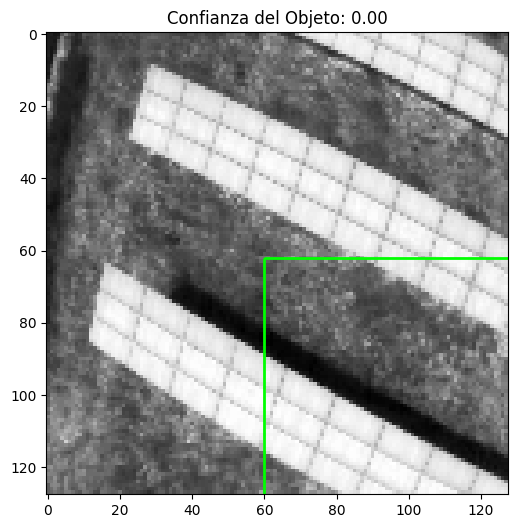

In [29]:
# --- Visualizar una predicción ---
print("\n🎯 Realizando una predicción en una imagen de prueba...")
# Tomamos una imagen del dataset de validación
for test_image, test_label in val_dataset.take(1):
    # Predecir
    pred_clase, pred_caja = modelo_completo.predict(tf.expand_dims(test_image, axis=0))

    # Desnormalizar la caja para dibujarla (multiplicar por el tamaño de la imagen)
    caja_predicha = pred_caja[0] * IMG_SIZE
    x, y, w, h = caja_predicha

    # Dibujar la imagen y la caja predicha
    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(test_image[:, :, 0], cmap='gray')

    # Crear el rectángulo
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)

    plt.title(f"Confianza del Objeto: {pred_clase[0][0]:.2f}")
    plt.show()



--- Predicción Final en la Imagen de Muestra ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


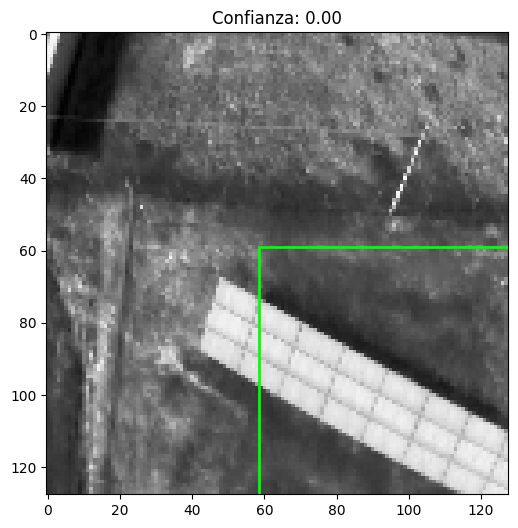

In [30]:
print("\n--- Predicción Final en la Imagen de Muestra ---")
# Usamos el modelo ya entrenado para predecir sobre nuestra imagen de muestra
final_clase, final_caja = modelo_completo.predict(image_batch)

# Desnormalizamos la caja para poder dibujarla
caja_predicha = final_caja[0] * IMG_SIZE
x, y, w, h = caja_predicha

# Dibujamos el resultado
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(sample_image[:, :, 0], cmap='gray')
rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
ax.add_patch(rect)
plt.title(f"Confianza: {final_clase[0][0]:.2f}")
plt.show()

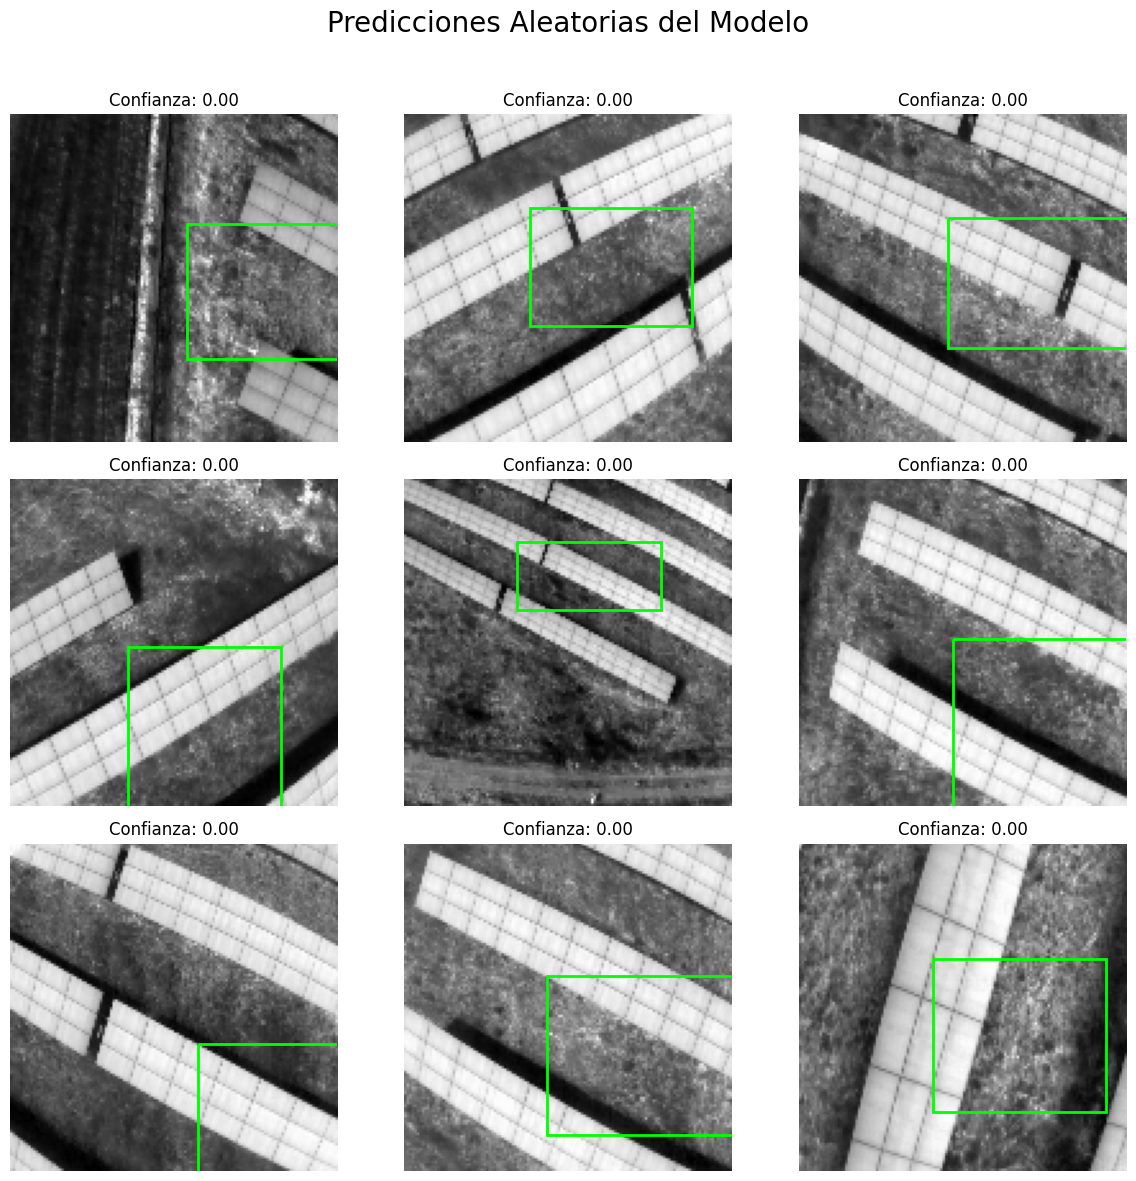

In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math

def mostrar_predicciones_aleatorias(model, dataset, num_imagenes=9):
    """
    Toma un modelo y un dataset, selecciona imágenes al azar y muestra
    las predicciones del modelo sobre ellas en una grilla.

    Args:
        model: El modelo de Keras ya entrenado.
        dataset: El tf.data.Dataset del cual tomar las imágenes.
                 (Usa el dataset original, ANTES de aplicar .batch()).
        num_imagenes (int): El número de imágenes aleatorias a mostrar.
    """
    # 1. Asegurarnos de que el dataset esté barajado para obtener imágenes aleatorias
    # Usamos un buffer_size de 1000 para una buena aleatoriedad.
    dataset_barajado = dataset.shuffle(buffer_size=1000)

    # 2. Tomar el número deseado de imágenes
    muestras = list(dataset_barajado.take(num_imagenes))

    # 3. Preparar la grilla de visualización
    # Calculamos cuántas filas y columnas necesitamos
    cols = int(math.ceil(math.sqrt(num_imagenes)))
    rows = int(math.ceil(num_imagenes / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    fig.suptitle('Predicciones Aleatorias del Modelo', fontsize=20)

    # Aplanar el array de ejes para iterar fácilmente
    axes = axes.flatten()

    # 4. Iterar, predecir y mostrar cada imagen
    for i, (imagen, etiqueta_real) in enumerate(muestras):
        ax = axes[i]

        # Preparar la imagen para la predicción (añadir dimensión de lote)
        imagen_lote = tf.expand_dims(imagen, axis=0)

        # Realizar la predicción
        pred_clase, pred_caja = model.predict(imagen_lote, verbose=0)

        # Procesar los resultados
        confianza = pred_clase[0][0]
        caja_normalizada = pred_caja[0]

        # Desnormalizar las coordenadas de la caja para dibujarlas (multiplicar por 128)
        caja_pixeles = caja_normalizada * 128.0
        x, y, w, h = caja_pixeles

        # Dibujar la imagen original
        ax.imshow(imagen[:, :, 0], cmap='gray')

        # Crear y añadir el rectángulo de la predicción
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

        # Añadir título con la confianza y apagar los ejes
        ax.set_title(f"Confianza: {confianza:.2f}")
        ax.axis('off')

    # Ocultar los ejes de las subtramas no utilizadas
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# EJEMPLO DE USO:

# Llama a la función para mostrar 9 predicciones del dataset de validación
mostrar_predicciones_aleatorias(modelo_completo, val_dataset, num_imagenes=9)

# Puedes probar con el dataset de prueba también
# mostrar_predicciones_aleatorias(modelo_completo, test_dataset, num_imagenes=4)

## Cambio en la Salida del Modelo

La salida ya no puede ser un solo vector de 5 números. Debe ser un tensor tridimensional que contenga las predicciones para cada celda

* Modelo Actual: Salida de (1 clase, 4 coordenadas).

* Nuevo Modelo: Salida con forma (S, S, 5), donde:

* S es el tamaño de la cuadrícula (ej. 4x4).

* 5 es el vector de predicción para cada celda: [confianza, x, y, ancho, alto].

- Confianza (Objectness): La probabilidad (0 a 1) de que un objeto
esté presente en esa celda.

- x, y, ancho, alto: Las coordenadas de la caja, relativas a la celda que la predice.

Acción: Modifiucación en el final del modelo. En lugar de Flatten y Dense, la última capa será una capa Conv2D que produce un tensor con la forma deseada.

In [32]:
# ... (El backbone convolucional se mantiene igual)
# backbone_output tiene una forma como (None, 16, 16, 128)

# En lugar de Flatten y Dense, usamos una última convolución
# para generar las predicciones para cada celda de la cuadrícula.
# Si la salida del backbone es 16x16, nuestra cuadrícula (S) será de 16.
# Usamos 5 filtros, uno para cada valor del vector de predicción.
output_tensor = Conv2D(5, (1, 1), activation='sigmoid', name='output_tensor')(backbone.output)

# El nuevo modelo ahora tiene una sola salida con forma (S, S, 5)
modelo_multibox = Model(inputs=backbone.input, outputs=output_tensor)

print("✅ Modelo Multi-Caja construido:")
modelo_multibox.summary()

✅ Modelo Multi-Caja construido:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_tensor (Conv2D)          │ (None, 16, 16, 5)      │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,317 (364.52 KB)

 Trainable params: 93,317 (364.52 KB)

 Non-trainable params: 0 (0.00 B)



*   image_label_mapping_train
*   image_label_mapping_test
*   image_label_mapping_val



train_images

test_images

val_images



* train_labels

* test_labels

* val_labels


train_images_processed

test_images_processed

val_images_processed

* train_labels_adapted
* test_labels_adapted
* val_labels_adapted

